In [15]:
import os
import numpy as np
import imageio
from IPython.display import clear_output
import optuna
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import sklearn
from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt
from attractors import Attractor
from sklearn.cluster import KMeans

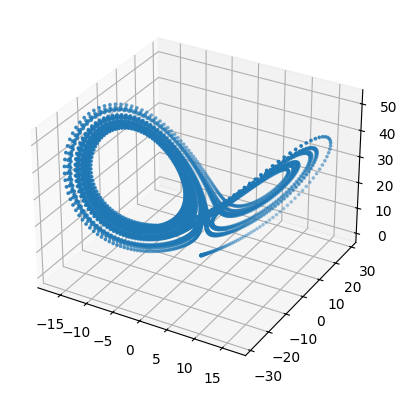

In [16]:
attr = Attractor("lorenz").rk4(0, 30, 5000)
df_lorenz = np.array([[i.X, i.Y, i.Z] for i in attr])
ax = plt.axes(projection="3d")
# ax.view_init(elev=20, azim=-70)
ax.scatter3D(df_lorenz.T[0], df_lorenz.T[1], df_lorenz.T[2], s=3)
plt.show()

The key idea is using Neiborhood Reconstruction. This method preserve the local geometry of the original data ditribution. First of all let's introduce the loss function.
$$
\mathcal{L}(\theta, \phi; \mathcal{D}) = \frac{1}{|\mathcal{D}|} \sum_{x \in \mathcal{D}} \frac{1}{|\mathcal{N}(x)|} \sum_{x' \in \mathcal{N}(x)} K(x', x) \cdot \|x' - \tilde{F}_{\theta,\phi}(x';x)\|^2
$$
where $K(x', x)$ is a positive symmetric kernel function that determines the weight for each $x' \in \mathcal{N}(x)$. We choose the following simple kernel
\begin{equation}
K(x', x) = \lambda + (1-\lambda)\delta(x', x),
\end{equation}
where $0 < \lambda < 1$ and $\delta(x', x) = 1$ if $x' = x$ and zero otherwise. This assigns the weight $1$ for the center $x \in \mathcal{N}(x)$ and the weight $\lambda$ for the remaining neighborhood points.

In case where we want to use information about linear in the neighborhood of the point, we may use the Jacobian of the function.

In [24]:
def get_kernel_function(kernel):
    if kernel['type'] == 'binary':
        def kernel_func(x_center, x_neighbors):
            batch_size = x_neighbors.size(0)
            num_neighbors = x_neighbors.size(1)
            x_center = x_center.view(batch_size, -1)
            x_neighbors = x_neighbors.view(batch_size, num_neighbors, -1)
            eps = 1.0e-12
            index = torch.norm(x_center.unsqueeze(1)-x_neighbors, dim=2) > eps
            output = torch.ones(batch_size, num_neighbors).to(x_center)
            output[index] = kernel['lambda']
            return output
    return kernel_func

class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        loss = ((recon - x) ** 2).view(len(x), -1).mean(dim=1).mean()
        mse_loss = F.mse_loss(recon, x)
        return {"recon": recon, "loss": loss, 'mse_loss': mse_loss}


class NRAE(AE):
    def __init__(self, encoder, decoder, approx_order=1, kernel=None):
        super().__init__(encoder, decoder)
        self.encoder = encoder
        self.decoder = decoder
        self.approx_order = approx_order
        self.kernel_func = get_kernel_function(kernel)

    def jacobian(self, z, dz, create_graph=True):
        batch_size = dz.size(0)
        num_neighbors = dz.size(1)
        z_dim = dz.size(2)

        v = dz.view(-1, z_dim)
        inputs = (z.unsqueeze(1).repeat(1, num_neighbors, 1).view(-1, z_dim))
        jac = torch.autograd.functional.jvp(self.decoder, inputs, v=v, create_graph=create_graph)[1].view(batch_size, num_neighbors, -1)
        return jac

    def jacobian_and_hessian(self, z, dz, create_graph=True):
        batch_size = dz.size(0)
        num_neighbors = dz.size(1)
        z_dim = dz.size(2)

        v = dz.view(-1, z_dim)
        inputs = (z.unsqueeze(1).repeat(1, num_neighbors, 1).view(-1, z_dim))

        def jac_temp(inputs):
            jac = torch.autograd.functional.jvp(self.decoder, inputs, v=v, create_graph=create_graph)[1].view(batch_size, num_neighbors, -1)
            return jac

        temp = torch.autograd.functional.jvp(jac_temp, inputs, v=v, create_graph=create_graph)

        jac = temp[0].view(batch_size, num_neighbors, -1)
        hessian = temp[1].view(batch_size, num_neighbors, -1)
        return jac, hessian
        
    def neighborhood_recon(self, z_center, z_neighbors):
        recon = self.decoder(z_center)
        recon_flat = recon.view(z_center.size(0), -1).unsqueeze(1)
        dz = z_neighbors - z_center.unsqueeze(1)
        
        if self.approx_order == 1:
            jacobian_dz = self.jacobian(z_center, dz)
            neighbor_recon = recon_flat + jacobian_dz
        elif self.approx_order == 2:
            jacobian_dz, dz_hessian_dz = self.jacobian_and_hessian(z_center, dz)
            neighbor_recon = recon_flat + jacobian_dz + 0.5*dz_hessian_dz
            
        return neighbor_recon

    def forward(self, x_center, x_neighbors=None):
        z_center = self.encoder(x_center)
        recon = self.decoder(z_center)
        
        if x_neighbors is None:
            loss = ((recon - x_center) ** 2).view(len(x_center), -1).mean(dim=1).mean()
            return {"recon": recon, "loss": loss}
        
        batch_size = x_neighbors.size(0)
        num_neighbors = x_neighbors.size(1)
        z_dim = z_center.size(1)
        
        z_neighbors = self.encoder(x_neighbors.view([-1] + list(x_neighbors.size()[2:]))).view(batch_size, -1, z_dim)
        neighbor_recon = self.neighborhood_recon(z_center, z_neighbors)
        neighbor_loss = torch.norm(x_neighbors.view(batch_size, num_neighbors, -1) - neighbor_recon, dim=2)**2
        weights = self.kernel_func(x_center, x_neighbors)
        loss = (weights*neighbor_loss).mean()
        
        return {"recon": neighbor_recon, "loss": loss}


l_sz = 16

def get_encoder(d_input=3, d_latent=1, layer_sz=l_sz, alpha=0.5):
    encoder = nn.Sequential(
        nn.Linear(d_input, layer_sz),
        # nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        # nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        # nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, d_latent)
    )
    return encoder

def get_decoder(d_latent=1, d_output=3, layer_sz=l_sz, alpha=0.5):
    decoder = nn.Sequential(
        nn.Linear(d_latent, layer_sz),
        # nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        # nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        # nn.BatchNorm1d(lay    er_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, d_output)
    )
    return decoder

In [25]:
class Dataset(Dataset):
   def __init__(self, data, targets=None):
       self.data = torch.from_numpy(data).float()

       self.targets = torch.from_numpy(targets).float() if targets is not None else None

   def __len__(self):
       return len(self.data)

   def __getitem__(self, idx):
       if self.targets is not None:
           return self.data[idx], self.targets[idx]
       else:
           return self.data[idx]

In [26]:
lorenz_dataset = Dataset(df_lorenz)
data_loader = DataLoader(lorenz_dataset, batch_size=256, shuffle=True)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

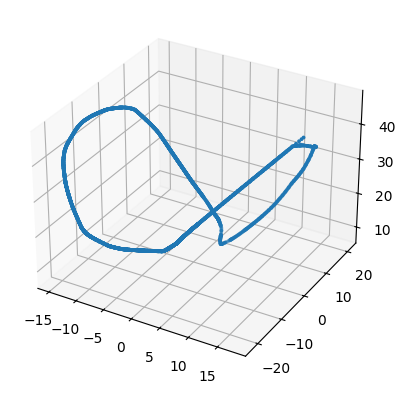

[I 2025-03-29 13:45:51,511] Trial 18 finished with value: 10.073955917514114 and parameters: {'hidden_dim': 128, 'learning_rate': 0.004951317548912404, 'batch_size': 128}. Best is trial 17 with value: 3.6981119865491987.



Trial 19
Current parameters: {'hidden_dim': 128, 'learning_rate': 0.0023685753903065765, 'batch_size': 128}


  0%|          | 2/2000 [00:00<02:11, 15.23it/s]
[I 2025-03-29 13:45:51,646] Trial 19 pruned. 


Best trial:
  Value:  3.6981119865491987
  Params: 
    hidden_dim: 128
    learning_rate: 0.00566815426645053
    batch_size: 128


In [28]:
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64, 128, 256]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256])
    }

    print(f"\nTrial {trial.number}")
    print(f"Current parameters:", trial.params)


    train_loader = DataLoader(
        lorenz_dataset,
        batch_size=params['batch_size'],
        shuffle=True
    )

    model = AE(
        encoder=get_encoder(3, 1, params['hidden_dim']),
        decoder=get_decoder(1, 3, params['hidden_dim']),
    ).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'],
        weight_decay=1e-5
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )

    criterion = nn.MSELoss()
    
    n_epochs = 2000
    losses = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_losses = []
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            recon = output['recon']
            loss = output['loss']
            mse_loss = output['mse_loss']
            loss.backward()
            optimizer.step()
            epoch_losses.append(mse_loss.item())

        scheduler.step(np.mean(epoch_losses))

        trial.report(np.mean(epoch_losses), epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        losses.append(np.mean(epoch_losses))

    output = model(lorenz_dataset.data.to(device))
    recon = np.array(output['recon'].data.cpu())
    
    clear_output()

    ax = plt.axes(projection="3d")
    ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3)
    
    plt.show()

    return np.mean(losses)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params
best_model = AE(
    encoder=get_encoder(3, 1, best_params['hidden_dim']),
    decoder=get_decoder(1, 3, best_params['hidden_dim']),
).to(device)
best_optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params['learning_rate'],
)

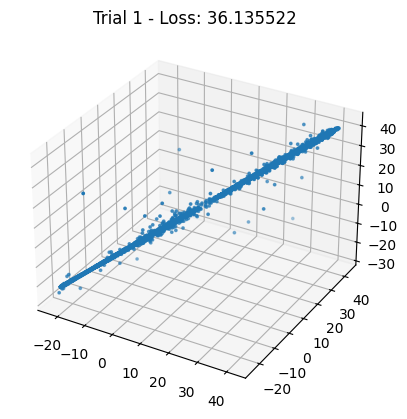

[I 2025-03-29 13:59:40,845] Trial 1 finished with value: 36.13552211084366 and parameters: {'hidden_dim': 128, 'learning_rate': 0.0033197036512170003, 'batch_size': 256, 'lambda': 0.3542648794097814, 'num_neighbors': 9}. Best is trial 1 with value: 36.13552211084366.



Trial 2
Current parameters: {'hidden_dim': 128, 'learning_rate': 0.006888154958095425, 'batch_size': 64, 'lambda': 0.2579425148775393, 'num_neighbors': 17}


  0%|          | 0/2000 [00:00<?, ?it/s]
[W 2025-03-29 13:59:41,269] Trial 2 failed with parameters: {'hidden_dim': 128, 'learning_rate': 0.006888154958095425, 'batch_size': 64, 'lambda': 0.2579425148775393, 'num_neighbors': 17} because of the following error: RuntimeError('selected index k out of range').
Traceback (most recent call last):
  File "/Users/nikitagreben/kaggle/venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/2d/h1jff3hx3cj01bwj6z1xp7bh0000gn/T/ipykernel_30960/1886861362.py", line 67, in objective_nrae
    batch_neighbors = get_neighbors(batch, k=params['num_neighbors'])
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/2d/h1jff3hx3cj01bwj6z1xp7bh0000gn/T/ipykernel_30960/1886861362.py", line 27, in get_neighbors
    _, indices = torch.topk(dist, k=k, dim=1, largest=False)
                 ^^^^^^^^^^^^^^^^^^^

RuntimeError: selected index k out of range

In [29]:
def objective_nrae(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64, 128, 256]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'lambda': trial.suggest_float('lambda', 1e-2, 1, log=True),
        'num_neighbors': trial.suggest_int('num_neighbors', 5, 20)
    }

    print(f"\nTrial {trial.number}")
    print(f"Current parameters:", trial.params)

    train_loader = DataLoader(
        lorenz_dataset,
        batch_size=params['batch_size'],
        shuffle=True
    )

    def get_neighbors(batch, k=10):
        batch_size = batch.size(0)
        feature_dim = batch.size(1)

        x1 = batch.unsqueeze(1)  # [batch_size, 1, feature_dim]
        x2 = batch.unsqueeze(0)  # [1, batch_size, feature_dim]
        dist = torch.sum((x1 - x2) ** 2, dim=2)  # [batch_size, batch_size]

        _, indices = torch.topk(dist, k=k, dim=1, largest=False)

        neighbors = torch.zeros(batch_size, k, feature_dim).to(batch.device)
        for i in range(batch_size):
            neighbors[i] = batch[indices[i]]
        
        return neighbors

    model = NRAE(
        encoder=get_encoder(3, 1, params['hidden_dim']),
        decoder=get_decoder(1, 3, params['hidden_dim']),
        approx_order=1,
        kernel={'type': 'binary', 'lambda': params['lambda']}
    ).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'],
        weight_decay=1e-5
    )
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )

    n_epochs = 2000
    losses = []
    
    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_losses = []
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            batch_neighbors = get_neighbors(batch, k=params['num_neighbors'])

            output = model(batch, batch_neighbors)
            
            loss = output['loss']
            mse_loss = output.get('mse_loss', loss)
            
            loss.backward()
            optimizer.step()
            epoch_losses.append(mse_loss.item())

        scheduler.step(np.mean(epoch_losses))
        trial.report(np.mean(epoch_losses), epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        losses.append(np.mean(epoch_losses))

    model.eval()
    with torch.no_grad():
        all_data = lorenz_dataset.data.to(device)
        all_neighbors = get_neighbors(all_data, k=params['num_neighbors'])
        
        output = model(all_data, all_neighbors)
        recon = output['recon'].cpu().numpy()
    
    clear_output()

    ax = plt.axes(projection="3d")
    ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3)
    plt.title(f'Trial {trial.number} - Loss: {np.mean(losses):.6f}')
    plt.show()

    return np.mean(losses)


study = optuna.create_study(direction="minimize")
study.optimize(objective_nrae, n_trials=20)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params

def get_neighbors(batch, k=10):
    batch_size = batch.size(0)
    feature_dim = batch.size(1)

    x1 = batch.unsqueeze(1)
    x2 = batch.unsqueeze(0)
    dist = torch.sum((x1 - x2) ** 2, dim=2)

    _, indices = torch.topk(dist, k=k, dim=1, largest=False)

    neighbors = torch.zeros(batch_size, k, feature_dim).to(batch.device)
    for i in range(batch_size):
        neighbors[i] = batch[indices[i]]
    
    return neighbors

best_model = NRAE(
    encoder=get_encoder(3, 1, best_params['hidden_dim']),
    decoder=get_decoder(1, 3, best_params['hidden_dim']),
    approx_order=1,
    kernel={'type': 'binary', 'lambda': best_params['lambda']}
).to(device)

best_optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=1e-5
)

best_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    best_optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

best_train_loader = DataLoader(
    lorenz_dataset,
    batch_size=best_params['batch_size'],
    shuffle=True
)

n_epochs = 5000
best_losses = []
num_neighbors = best_params.get('num_neighbors', 10)

print("\nTraining best model...")
for epoch in tqdm(range(n_epochs)):
    best_model.train()
    epoch_losses = []
    
    for batch in best_train_loader:
        batch = batch.to(device)
        best_optimizer.zero_grad()
        
        batch_neighbors = get_neighbors(batch, k=num_neighbors)
        
        output = best_model(batch, batch_neighbors)
        
        loss = output['loss']
        mse_loss = output.get('mse_loss', loss)
        
        loss.backward()
        best_optimizer.step()
        epoch_losses.append(mse_loss.item())
    
    avg_loss = np.mean(epoch_losses)
    best_losses.append(avg_loss)
    best_scheduler.step(avg_loss)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")


Here we use `torch.autograd.functional.jvp` to optimize the calculation of the Jacobian-vector product. It works in the following way: when we calculate the Jacobian matrix directly, we have to create the whole Jacobian matrix $n \times n$, which can be computationally expensive ($O(n^2)$). Instead of calculating the whole matrix, one can use the following trick: we can use the `grad_outputs` argument in `torch.autograd.grad` to apply weights to the gradients.

First, we calculate the outputs of the function.


```python
outputs = func(*inputs)
grad_outputs = tuple(
    torch.zeros_like(out, requires_grad=True)
    for out in outputs
)
```
We use these outputs as weights for the `grad_outputs` parameter. Then we can calculate the first backward pass.

```python
grad_x = torch.autograd.grad(
    outputs,
    x,
    grad_outputs=grad_outputs,
    create_graph=True
)[0]
```

After the first backward operation, we receive the linearization of the initial function at the given points. Then we perform the second backward pass.

```python
jvp = torch.autograd.grad(
    grad_x,
    grad_outputs,
    grad_outputs=v
)
```
Hence, the first backward pass computes the differential at the point, while the second computes the effect of the differential on the vector $v$. In our autoencoder, the vectors are the shifted neighbor vectors.

Simple example:

$$f(x) = x^2$$

$$\downarrow$$

$$\text{First backward}: \frac{\partial f}{\partial x} = 2x \cdot \text{grad\_outputs}$$

$$\downarrow$$

$$\text{Second backward: } \frac{\partial(2x \cdot \text{grad\_outputs})}{\partial \text{grad\_outputs}} \cdot v = 2x \cdot v$$